In [3]:
import pandas as pd
import re
from datetime import date
import seaborn as sns

In [ ]:
steam = pd.read_csv("../data/updated_steam_games.csv")





In [16]:
# Select the Series (the column from the filtered row)
description_series = steam[steam['appid'] == 2749350]['pct_pos_total']

# Extract the actual string from the Series
description_string = description_series.iloc[0]
description_string

np.int64(70)

In [31]:
steam['game_age'] = (pd.to_datetime('today') - pd.to_datetime(steam['release_date'])).dt.days

In [32]:
def categorize_release_month(x : date):
    return x.month
steam['release_month'] = steam['release_date'].apply(categorize_release_month)

In [33]:
def categorize_week_of_year(x :date):
    return (x.month * 30 + x.day) / 365
        
steam['week_of_year'] = steam['release_date'].apply(categorize_week_of_year)
print(steam['week_of_year'].head())

4     0.989041
6     0.454795
7     0.186301
8     0.983562
10    0.709589
Name: week_of_year, dtype: float64


In [1]:
import calendar


def find_fourth_thursday(year):
    """Finds the date of the fourth Thursday in November for a given year."""
    # Get a list of weeks for November of the given year
    # Each week is a list of day numbers (0 if not in the month)
    month_cal = calendar.monthcalendar(year, 11)

    # Find all Thursdays in the month
    # calendar.THURSDAY is the index for Thursdays (which is 3)
    thursdays = [week[calendar.THURSDAY] for week in month_cal if week[calendar.THURSDAY] != 0]
    
    # The fourth Thursday is the fourth item in our list (at index 3)
    fourth_thursday_day = thursdays[3]
    
    return date(year, 11, fourth_thursday_day)

def is_holiday_season(x):
    year = x.year
    thanksgiving_date = find_fourth_thursday(year)
    new_years = date(year, 12, 31)
    return thanksgiving_date <= x <= new_years
steam['is_holiday_season'] = steam['release_date'].apply(is_holiday_season)

NameError: name 'steam' is not defined

In [35]:
def is_summer_season(x : date):
    month = x.month
    return 6 <= month <= 8
steam['is_summer_season'] = steam['release_date'].apply(is_summer_season)

In [36]:
import pandas as pd
import ast

def to_dict_if_str(v):
    """
    • If the value is a non-empty string → safely parse it with ast.literal_eval  
    • If it is already a dict (or NaN/empty) → leave it unchanged
    """
    if isinstance(v, str) and v.strip():
        return ast.literal_eval(v)
    return v                  # dict, NaN, '' … are returned untouched

# clean + parse once
steam = steam[steam['tags'].notna()]        # drop NaNs if any
steam['tags'] = steam['tags'].apply(to_dict_if_str)

def get_top_n_tags(tag_dict: dict, n: int = 3):
    if not tag_dict:                       # empty / NaN safety
        return []
    sorted_items = sorted(tag_dict.items(),
                          key=lambda kv: kv[1],
                          reverse=True)
    return [k for k, _ in sorted_items[:n]]

steam['top_tags'] = steam['tags'].apply(get_top_n_tags,2)


/var/folders/qh/rp_bx0z54rldzblsdk7jf8980000gn/T/ipykernel_65004/2560932343.py:25: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  steam['top_tags'] = steam['tags'].apply(get_top_n_tags,2)


In [37]:
from sklearn.preprocessing import MultiLabelBinarizer

# Initialize the MultiLabelBinarizer
mlb = MultiLabelBinarizer()

# Fit and transform the 'top3_tags' column
encoded_tags = mlb.fit_transform(steam['top_tags'])

# Create a new DataFrame with the encoded tags
# The `mlb.classes_` attribute holds the names of all unique tags
encoded_df = pd.DataFrame(encoded_tags, columns=mlb.classes_, index=steam.index)

# Concatenate the new encoded DataFrame with the original steam DataFrame
steam_encoded = pd.concat([steam, encoded_df], axis=1)

# Display the first few rows with the new encoded columns
print(steam_encoded.head())


      appid                             name release_date  required_age  \
4    359550  Tom Clancy's Rainbow Six® Siege   2015-12-01            17   
6    105600                         Terraria   2011-05-16             0   
7    252490                             Rust   2018-02-08             0   
8      4000                      Garry's Mod   2006-11-29             0   
10  2358720               Black Myth: Wukong   2024-08-19            13   

    price  dlc_count                               detailed_description  \
4    3.99          9  Edition Comparison Ultimate Edition The Tom Cl...   
6    9.99          2  Dig, Fight, Explore, Build: The very world is ...   
7   39.99          4  The only aim in Rust is to survive. Everything...   
8    5.99          0  Garry's Mod is a physics sandbox. There aren't...   
10  59.99          2  Digital Deluxe Edition The Black Myth: Wukong ...   

                                       about_the_game  \
4   “One of the best first-person shooter

In [38]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, root_mean_squared_error
import numpy as np


base_features = [
    'release_month',
    'game_age'
]
encoded_tag_features = list(mlb.classes_)

all_features = base_features + encoded_tag_features

X = steam_encoded[all_features]
y = np.log1p(steam_encoded['num_reviews_total'])


X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=42)

model = RandomForestRegressor()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse) # Calculate RMSE by taking the square root of MSE
r2 = r2_score(y_test, y_pred)

# --- Or, for RMSE, use the 'squared' parameter (more direct) ---
rmse_direct = root_mean_squared_error(y_test, y_pred)


print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R-squared (R²): {r2:.2f}")

y_pred_original_scale = np.expm1(y_pred)
y_test_original_scale = np.expm1(y_test)

# Calculate MAE on the original scale
mae_original_scale = mean_absolute_error(y_test_original_scale, y_pred_original_scale)

print(f"Mean Absolute Error on Original Scale: {mae_original_scale:.2f} reviews")


Mean Absolute Error (MAE): 0.91
Mean Squared Error (MSE): 2.07
Root Mean Squared Error (RMSE): 1.44
R-squared (R²): -0.68
Mean Absolute Error on Original Scale: 49213.24 reviews


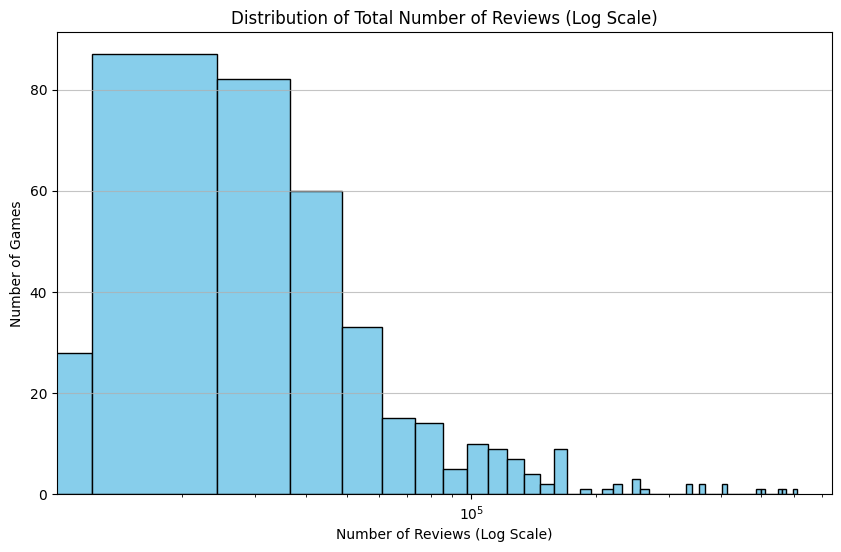

In [39]:
import matplotlib.pyplot as plt
import numpy as np

# Create the histogram
plt.figure(figsize=(10, 6))
plt.hist(steam_encoded['num_reviews_total'], bins=50, color='skyblue', edgecolor='black')

# Use a logarithmic scale for the x-axis
plt.xscale('log')

# Add titles and labels for clarity
plt.title('Distribution of Total Number of Reviews (Log Scale)')
plt.xlabel('Number of Reviews (Log Scale)')
plt.ylabel('Number of Games')
plt.grid(axis='y', alpha=0.75)

# Display the plot
plt.show()

Average Total Reviews by Release Month:
Month Name  Average Total Reviews
  February           98704.444444
  December           93917.068966
  November           73111.121212
       May           70386.862069
    August           67645.757576
      July           55143.416667
 September           50540.469388
   October           49940.800000
      June           48426.166667
     March           42681.781250
   January           39587.100000
     April           37884.611111


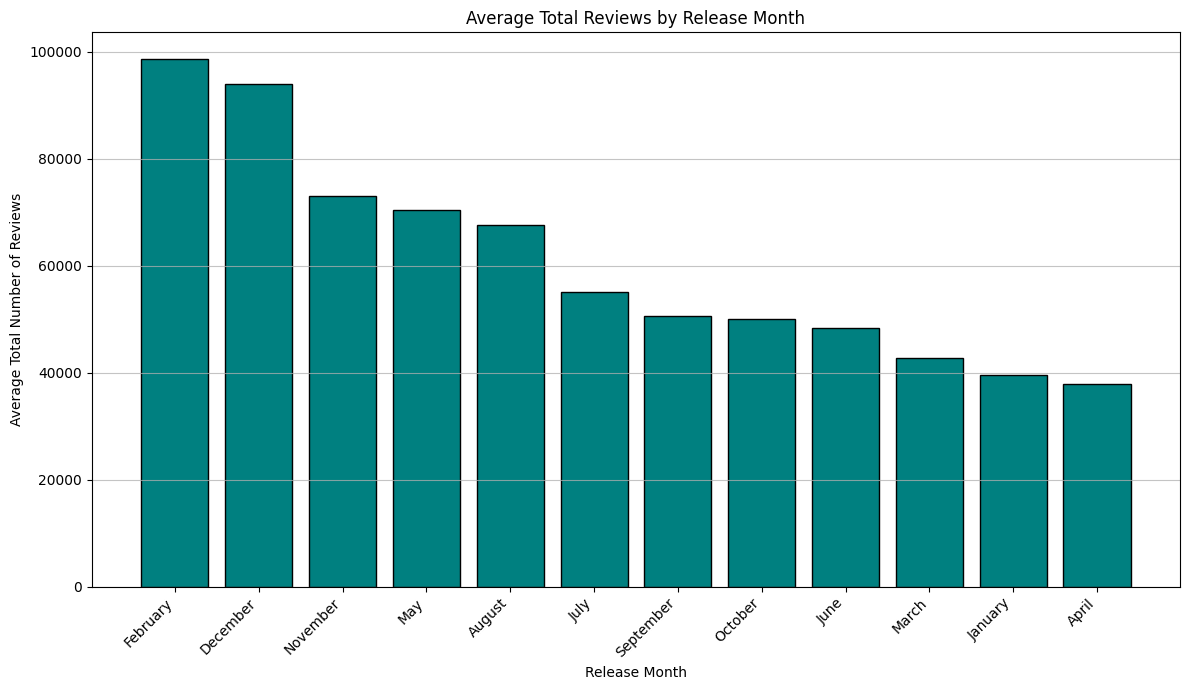

In [40]:
import matplotlib.pyplot as plt
import pandas as pd

# Group by release month and calculate the average number of total reviews
monthly_avg_reviews = steam.groupby('release_month')['num_reviews_total'].mean().reset_index()
monthly_avg_reviews.columns = ['Month', 'Average Total Reviews']

# Sort the months by the average reviews to see which are best
monthly_avg_reviews = monthly_avg_reviews.sort_values(by='Average Total Reviews', ascending=False)

# Convert month number to month name for better readability
monthly_avg_reviews['Month Name'] = monthly_avg_reviews['Month'].apply(lambda x: pd.to_datetime(str(x), format='%m').strftime('%B'))

# Print the aggregated table
print("Average Total Reviews by Release Month:")
print(monthly_avg_reviews[['Month Name', 'Average Total Reviews']].to_string(index=False))

# --- Visualization ---
plt.figure(figsize=(12, 7))
plt.bar(monthly_avg_reviews['Month Name'], monthly_avg_reviews['Average Total Reviews'], color='teal', edgecolor='black')

plt.title('Average Total Reviews by Release Month')
plt.xlabel('Release Month')
plt.ylabel('Average Total Number of Reviews')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.75)
plt.tight_layout()

plt.show()

Average Peak CCU by Release Month:
Month Name  Average Peak Concurrent Users
  February                  177036.388889
    August                  161000.757576
   January                  113020.300000
  December                   83288.620690
 September                   77064.066667
  November                   72830.343750
       May                   72194.000000
   October                   61195.914286
     March                   60810.687500
      July                   49645.583333
      June                   49209.586207
     April                   42466.916667


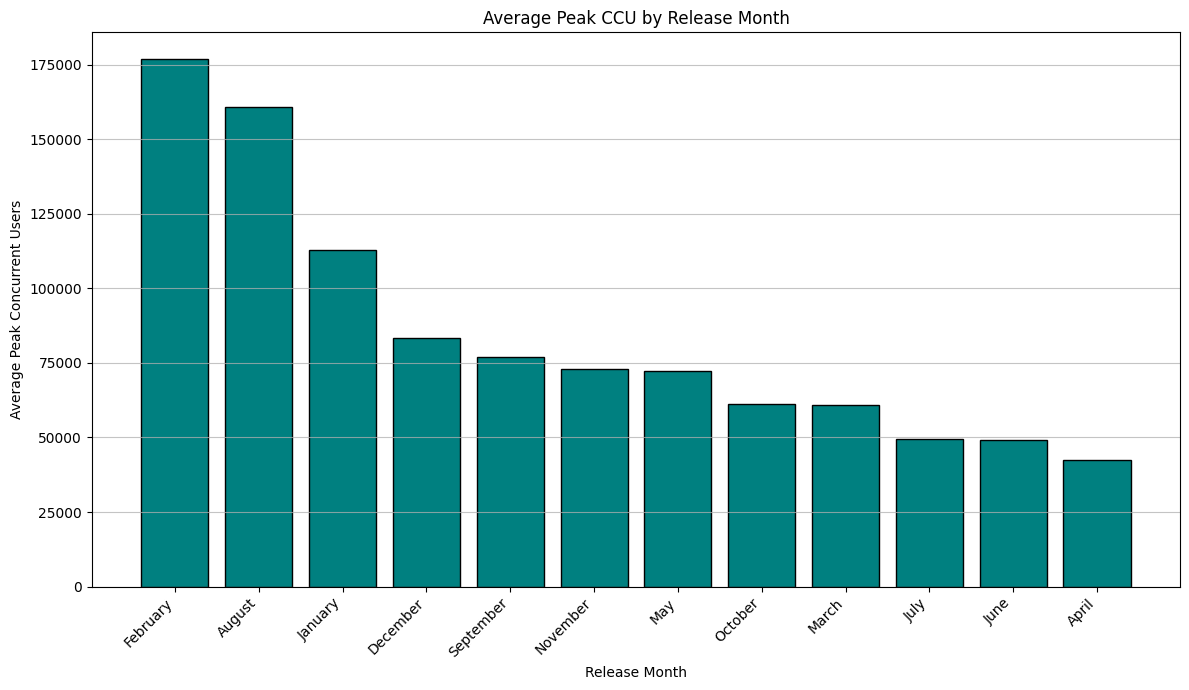

In [41]:
# Group by release month and calculate the average number of total reviews
filtered_steam = steam_encoded
filtered_steam = filtered_steam[filtered_steam['peak_ccu'] > 0]
monthly_avg_reviews = filtered_steam.groupby('release_month')['peak_ccu'].mean().reset_index()
monthly_avg_reviews.columns = ['Month', 'Average Peak Concurrent Users']

# Sort the months by the average reviews to see which are best
monthly_avg_reviews = monthly_avg_reviews.sort_values(by='Average Peak Concurrent Users', ascending=False)

# Convert month number to month name for better readability
monthly_avg_reviews['Month Name'] = monthly_avg_reviews['Month'].apply(lambda x: pd.to_datetime(str(x), format='%m').strftime('%B'))

# Print the aggregated table
print("Average Peak CCU by Release Month:")
print(monthly_avg_reviews[['Month Name', 'Average Peak Concurrent Users']].to_string(index=False))

# --- Visualization ---
plt.figure(figsize=(12, 7))
plt.bar(monthly_avg_reviews['Month Name'], monthly_avg_reviews['Average Peak Concurrent Users'], color='teal', edgecolor='black')

plt.title('Average Peak CCU by Release Month')
plt.xlabel('Release Month')
plt.ylabel('Average Peak Concurrent Users')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.75)
plt.tight_layout()

plt.show()

Average Peak CCU by Required Age:
 Required Age  Average Peak Concurrent Users
            0                   76936.790262
           13                  393614.000000
           16                  171012.500000
           17                   86539.032609
           18                  123123.333333


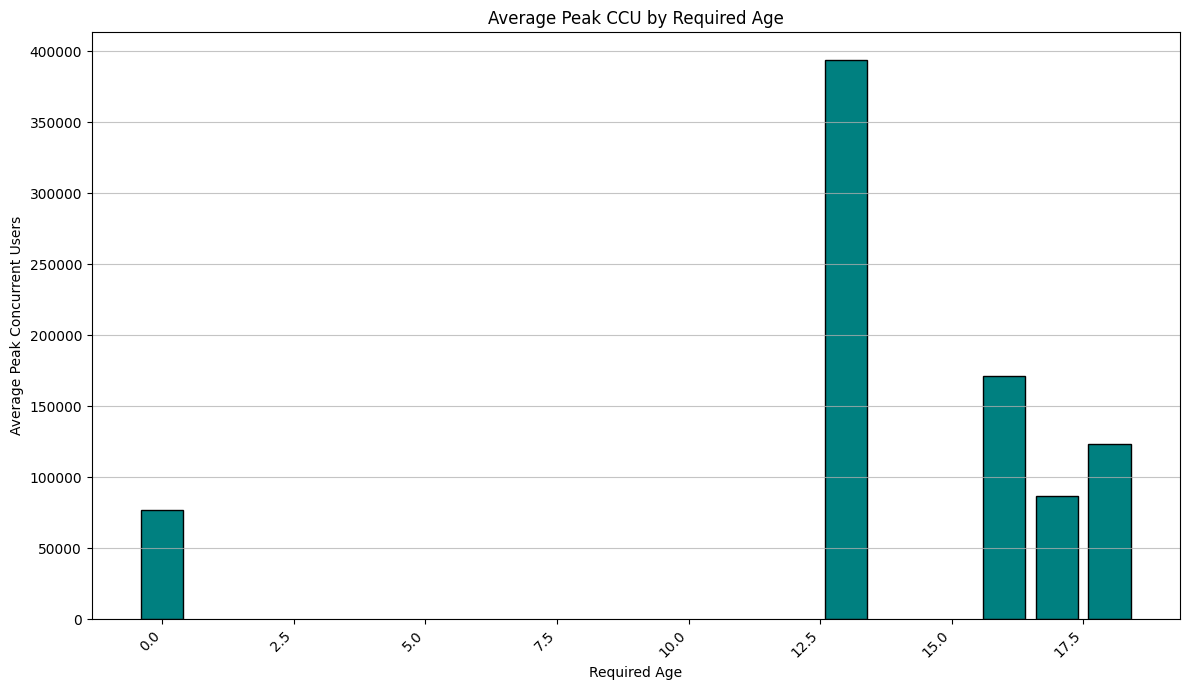

In [42]:
age_reviews = filtered_steam.groupby('required_age')['peak_ccu'].mean().reset_index()
age_reviews.columns = ['Required Age', 'Average Peak Concurrent Users']


# Print the aggregated table
print("Average Peak CCU by Required Age:")
print(age_reviews[['Required Age', 'Average Peak Concurrent Users']].to_string(index=False))

# --- Visualization ---
plt.figure(figsize=(12, 7))
plt.bar(age_reviews['Required Age'], age_reviews['Average Peak Concurrent Users'], color='teal', edgecolor='black')

plt.title('Average Peak CCU by Required Age')
plt.xlabel('Required Age')
plt.ylabel('Average Peak Concurrent Users')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.75)
plt.tight_layout()

plt.show()

In [ ]:
# First, filter the DataFrame to only include games with a peak_ccu greater than 0
non_zero_ccu_df = filtered_steam[filtered_steam['peak_ccu'] > 0]

# Now, find the index of the row with the minimum peak_ccu in this new DataFrame
min_ccu_index = non_zero_ccu_df['peak_ccu'].idxmin()

# Use .loc to retrieve and display the entire row for that game
game_with_min_ccu = non_zero_ccu_df.loc[min_ccu_index]

print("Game with the minimum non-zero Peak CCU:")


Game with the minimum non-zero Peak CCU:
550
